# MLP Network without Keras

(2, 1000) (1000,)


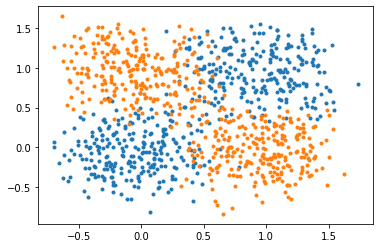

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle

# load data
D = pickle.load(open("xorData.p", "rb"))
# print(D)

X = D.data - 0.5
y = D.target

print(X.shape, y.shape)
# print(X1[:,0])

plt.figure()
plt.plot(X[0, y == 0], X[1, y == 0], '.')
plt.plot(X[0, y == 1], X[1, y == 1], '.')
# plt.plot(X[0, :], X[1, :], '.')
# plt.plot(y1, y1, '.')
plt.show()


### Network training algorithm a)


In [2]:
def train(
    X=X,
    y=y,
    hidden_units=10,
    adaptation_step=1e-5,  # eta
    moment_term=0.9,  # alpha
    number_of_iterations=500,  # iter
    activation_function=np.tanh,
):

    # Each row for each input
    # Each column for each hidden neuron
    # Start the hidden layer weights with low random values
    Wi = rd.randn(2, hidden_units) * .1
    # print(Wi)

    # Each row for each hidden neuron
    b = np.zeros((hidden_units, 1))
    # print(b)

    # Each row for the output of each hidden neuron
    # Start the output layer weights with low random values
    Wo = rd.randn(hidden_units, 1) * .1
    # print(Wo)

    # Bias for the output layer
    bo = 0

    # Initialize the derivatives
    dzWi = np.zeros(Wi.shape)
    dzb = np.zeros(b.shape)
    dzWo = np.zeros(Wo.shape)
    dzbo = 0

    Error = np.zeros(number_of_iterations)

    for n in range(number_of_iterations):
        # forward pass
        u = np.dot(Wi.T, X) + b
        v = activation_function(u)
        z = np.dot(Wo.T, v) + bo
        yh = activation_function(z)

        # error
        E = y-yh
        Error[n] = np.mean(E**2)

        # gradient
        dz = -2*E*(1-yh**2)
        dbo = np.sum(dz)
        dWo = np.dot(v, dz.T)
        du = (1-v**2)*np.dot(Wo, dz)
        db = np.sum(du, axis=1)
        dWi = np.dot(X, du.T)

        # adapt
        dzWi = moment_term * dzWi + dWi
        dzb = moment_term * dzb + db[:, np.newaxis]
        dzWo = moment_term * dzWo + dWo
        dzbo = moment_term * dzbo + dbo

        Wi = Wi - adaptation_step * dzWi
        b = b - adaptation_step * dzb
        Wo = Wo - adaptation_step * dzWo
        bo = bo - adaptation_step * dzbo

    return Error, yh, Wi, b, Wo, bo


### Train network b) c) d)


Hidden units: 1


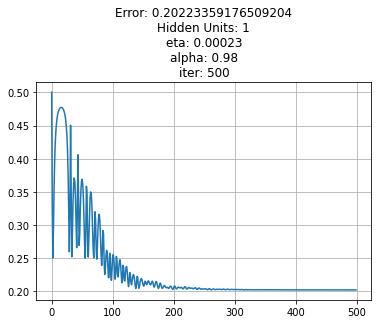

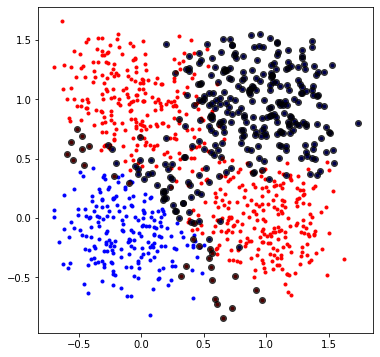

Nº of errors: 322


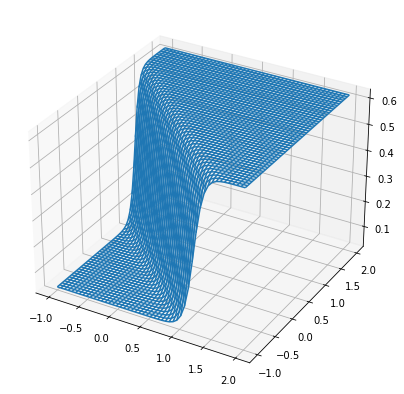

Hidden units: 10


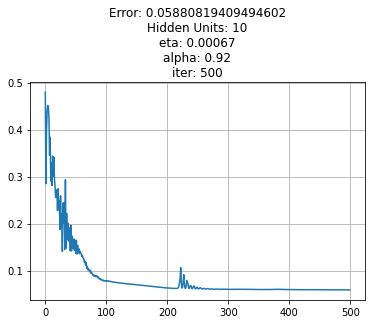

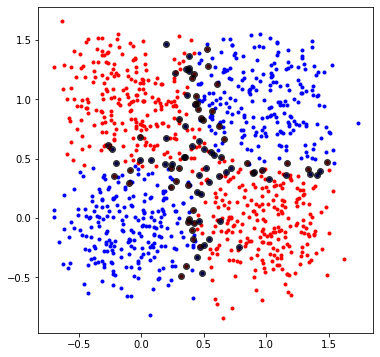

Nº of errors: 84


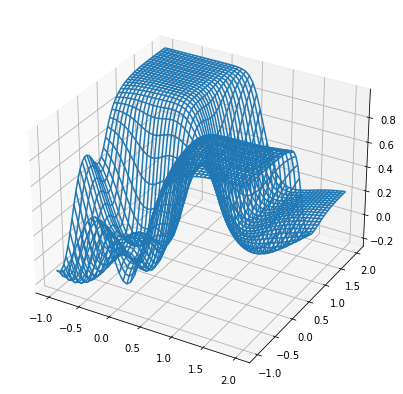

Hidden units: 50


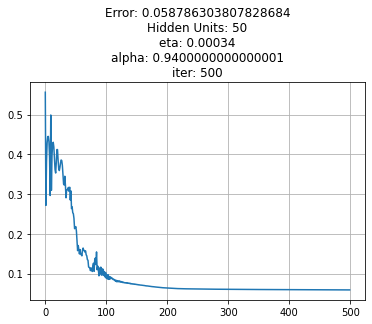

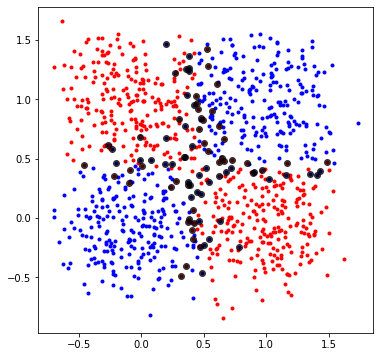

Nº of errors: 85


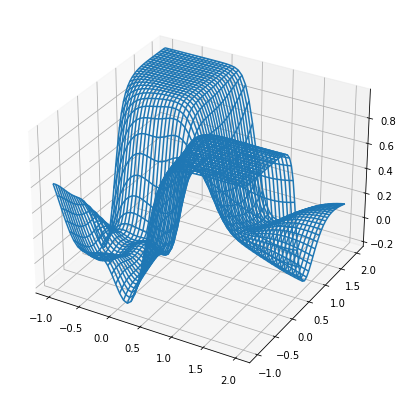

In [3]:
# For 1, 10 and 50 hidden units
for hu in [1, 10, 50]:
    print("Hidden units:", hu)
    best = 1
    best_error = []
    best_yh = []
    best_eta = 0
    best_alpha = 0
    best_Wi = []
    best_b = []
    best_Wo = []
    best_bo = 0
    for eta in np.linspace(1e-5, 1e-3, 10):
        for alpha in np.linspace(0.9, 0.99, 10):
            Error, yh, Wi, b, Wo, bo = train(X, y,
                                             hidden_units=hu,
                                             adaptation_step=eta,  # eta
                                             moment_term=alpha,  # alpha
                                             number_of_iterations=500,  # iter
                                             )

            if Error[len(Error)-1] < best:
                best = Error[len(Error)-1]
                best_error = Error.copy()
                best_yh = yh.copy()
                best_Wi = Wi.copy()
                best_b = b.copy()
                best_Wo = Wo.copy()
                best_bo = bo
                best_eta = eta
                best_alpha = alpha

    plt.figure()
    plt.plot(best_error)
    plt.title('Error: ' + str(best) +
              '\nHidden Units: ' + str(hu) +
              '\neta: ' + str(best_eta) +
              '\nalpha: ' + str(best_alpha) +
              '\niter: ' + str(len(best_error)))
    plt.grid(True)
    plt.show()

    # Training set errors

    plt.figure(figsize=(6, 6))
    ye = (best_yh.squeeze() >= 0.5)
    plt.plot(X[0, y == 0], X[1, y == 0], '.b')
    plt.plot(X[0, y == 1], X[1, y == 1], '.r')
    plt.plot(X[0, y != ye], X[1, y != ye], 'ok', alpha=.7)
    plt.show()
    print('Nº of errors:', np.sum(y != ye))

    # Wireframe

    gX, gY = np.meshgrid(np.linspace(-1, 2, 50), np.linspace(-1, 2, 50))
    X2 = np.vstack((gX.ravel(), gY.ravel()))
    u = np.dot(best_Wi.T, X2)+best_b
    v = np.tanh(u)
    z = np.dot(best_Wo.T, v)
    yh = np.tanh(z+best_bo)
    Yh = np.reshape(yh, (50, 50))

    fig = plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    # ax.contour3D(gX,gY,Yh,50,cmap='binary')
    ax.plot_wireframe(gX, gY, Yh)
    plt.show()


We can see that when we train with 1 hidden unit, the network is not able to learn the function because with only 1 hidden unit, there's no way differentiate the data with an intersection

With 10 or 50 units we see not much difference, indicating that adding more hidden units is not usefull. Maybe a better result could be achieved increasing the number of hidden layers instead of the number of hidden units

We can see that the best alpha is close to 1 because at the end of the iterations, the network was able to reach that error value relatively fast compared to other alpha values


# MLP Network with Keras

### a)

In [28]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from skimage import color
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()

# Transform data into array from 1-col matrix
ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

# Randomize train data
idx = rd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

# Sort test data
idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]

# Convert to grayscale
XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])

# Convert to vector
XtrainGV = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestGV = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

# Categorical
ytrainC = keras.utils.to_categorical(ytrain)
ytestC = keras.utils.to_categorical(ytest)

X1_train, X1_val, y1_train, y1_val = train_test_split(
    XtrainGV, ytrainC, test_size=0.2)

# Pre-processing
ss = StandardScaler().fit(XtrainGV)
XtrainGVp = ss.transform(XtrainGV)
XtestGVp = ss.transform(XtestGV)
X1_trainP = ss.transform(X1_train)
X1_valP = ss.transform(X1_val)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [29]:
X1 = XtrainGV
y1 = ytrain
y1C = ytrainC

X1p = XtrainGVp
X1s = X1_train
X1sp = X1_trainP
X1sVal = X1_val
X1sValP = X1_valP
y1s = y1_train
y1sVal = y1_val

X2 = XtestGV
X2p = XtestGVp
y2 = ytest
y2C = ytestC


In [6]:
nn = keras.Sequential()
nn.add(keras.layers.Flatten(input_shape=(32*32,)))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(100, activation="relu"))
nn.add(keras.layers.Dense(10, activation="softmax"))

nn.compile(optimizer="nadam",
           loss=keras.losses.mean_squared_error,
           metrics=["accuracy"],
           )

print(nn.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

Epoch 1/100
49/49 [==============================] - 2s 37ms/step - loss: 0.0895 - accuracy: 0.1268 - val_loss: 0.0901 - val_accuracy: 0.1190
Epoch 2/100
49/49 [==============================] - 1s 25ms/step - loss: 0.0879 - accuracy: 0.1695 - val_loss: 0.0882 - val_accuracy: 0.1635
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.0873 - accuracy: 0.1846 - val_loss: 0.0871 - val_accuracy: 0.1862
Epoch 4/100
49/49 [==============================] - 1s 26ms/step - loss: 0.0856 - accuracy: 0.2203 - val_loss: 0.0844 - val_accuracy: 0.2483
Epoch 5/100
49/49 [==============================] - 1s 28ms/step - loss: 0.0850 - accuracy: 0.2352 - val_loss: 0.0841 - val_accuracy: 0.2495
Epoch 6/100
49/49 [==============================] - 1s 24ms/step - loss: 0.0839 - accuracy: 0.2574 - val_loss: 0.0847 - val_accuracy: 0.2428
Epoch 7/100
49/49 [==============================] - 1s 24ms/step - loss: 0.0833 - accuracy: 0.2694 - val_loss: 0.0821 - val_accuracy: 0.2917
Epoch 

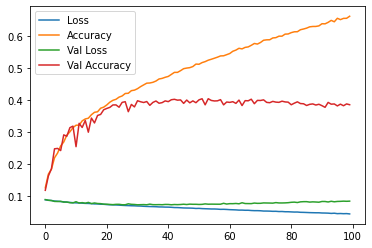

In [7]:
train = nn.fit(X1, y1C,
               epochs=50,
               batch_size=1024,
               validation_data=(X2, y2C),
               use_multiprocessing=True,
               )

h = train.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Accuracy')
plt.legend()
plt.show()


In [17]:
y2e = nn.predict(X2)
y2p = np.argmax(y2e, axis=1)

print('Nº of errors:', np.sum(y2 != y2p))


Nº of errors: 6144


Despite the accuracy increasing, the val_accuracy doesn't improve, indicating that the network stopped learning for new inputs and is now memorizing the training data
We confirm that seeing that the val_loss started increasing a little bit at 50 epochs +-


### b)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               102500    
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 100)              

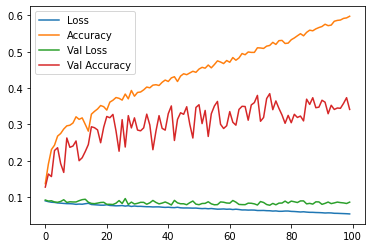

In [30]:
nn = keras.Sequential()
nn.add(keras.layers.Flatten(input_shape=(32*32,)))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(100, activation="tanh"))
nn.add(keras.layers.Dense(10, activation="softmax"))

nn.compile(optimizer="nadam",
           loss=keras.losses.mean_squared_error,
           metrics=["accuracy"],
           )

print(nn.summary())

train = nn.fit(X1sp, y1s,
               epochs=100,
               batch_size=1024,
               validation_data=(X1sValP, y1sVal),
               use_multiprocessing=True,
               )

h = train.history
plt.plot(h["loss"], label='Loss')
plt.plot(h["accuracy"], label='Accuracy')
plt.plot(h["val_loss"], label='Val Loss')
plt.plot(h["val_accuracy"], label='Val Accuracy')
plt.legend()
plt.show()


In [32]:
y2e = nn.predict(X2p)
y2p = np.argmax(y2e, axis=1)

print('Nº of errors:', np.sum(y2 != y2p))


Nº of errors: 9023
